# **1. Hate speech detection model 1**

**1.Data Sources or RL Tasks**

Data Source Documentation:
We used two datasets to train this data model  
One CSV is assumed to contain columns for tweet text and class labels, among others, which are dropped during preprocessing. 
The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
hate_speech = number of CF users who judged the tweet to be hate speech.
offensive_language = number of CF users who judged the tweet to be offensive.
neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

Another dataset:
post_id : Unique id for each post
annotators : The list of annotations from each annotator
annotators[label] : The label assigned by the annotator to this post. Possible values: [Hatespeech, Offensive, Normal]
annotators[annotator_id] : The unique Id assigned to each annotator
annotators[target] : A list of target community present in the post
rationales : A list of rationales selected by annotators. Each rationales represents a list with values 0 or 1. A value of 1 means that the token is part of the rationale selected by the annotator. To get the particular token, we can use the same index position in "post_tokens"
post_tokens : The list of tokens representing the post which was annotated

**2.Exploratory Analysis of Data or RL Tasks**

Data Properties:

Number of Classes: The script does not explicitly mention the number of classes, but this can be inferred from the unique values in the 'class' column of the dataset.
Pre-processing:
Special characters are replaced.
Usernames and URLs are replaced with placeholders (<user>, <url>).
Emojis and emoticons are replaced with <emoticon>.
Numbers are replaced with <number>.
Hashtags are replaced with <hashtag>.
Punctuation is removed, and multiple spaces are replaced with a single space.
Challenging Aspects:
Handling various forms of textual noise such as usernames, URLs, emojis, and emoticons is addressed. The preprocessing steps should be detailed in the report.

**3. Models and/or Methods**
    
Model1:
The model is a combination of BERT and a CNN for text classification. Here’s a breakdown of the model:

BERT: Used for extracting rich contextual embeddings from text.
CNN: Applied on the embeddings to capture local patterns.
Fully Connected Layer: Followed by a dropout layer for regularization.
LogSoftmax: Applied to the output for classification.
    
Models and Methods
Model Architecture:

BERT: Extracts contextual embeddings from the text.
CNN: Captures local patterns in the BERT embeddings.
Fully Connected Layer: Followed by dropout for regularization.
LogSoftmax: For classification output.
Training and Evaluation:

Optimizer: AdamW with a learning rate of 5e-5.
Loss Function: Negative Log-Likelihood Loss.
Training Strategy: Gradient clipping and accumulation, with a validation check after each epoch.
Recommendations for Improvement
    
Memory Management:
Reduce batch size to prevent OutOfMemoryError.
Implement mixed precision training if possible.
Free up GPU memory before starting new tasks.


In [ ]:
import gc
import re
import numpy as np
import emoji
import string
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Pre-processing Functions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def read_dataset():
    # Read the dataset from the CSV file
    data = pd.read_csv("labeled_data.csv")
    # Drop unnecessary columns
    data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    print(len(data))
    return data['tweet'].tolist(), data['class']

def pre_process_dataset(values):
    new_values = []
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D', '=)', '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@', ':>', ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp', ':-|', ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Lowercase the text and replace dots with spaces
        text = value.replace(".", " ").lower()
        # Remove non-alphanumeric characters except punctuation
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        # Replace usernames with <user> placeholder
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        # Replace URLs with <url> placeholder
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url>")
        # Replace emojis with <emoticon> placeholder
        for emo in text:
            if emo in emoji.EMOJI_DATA:
                text = text.replace(emo, "<emoticon>")
        # Replace emoticons with <emoticon> placeholder
        for emo in emoticons:
            text = text.replace(emo, "<emoticon>")
        # Replace numbers with <number> placeholder
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number>")
        # Replace hashtags with <hashtag> placeholder
        text = text.replace('#', "<hashtag>")
        # Replace punctuation with space
        text = re.sub(r"([?.!,¿])", r" ", text)
        # Remove punctuation and normalize spaces
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values

def data_process(data, labels):
    input_ids = []
    attention_masks = []
    # Initialize BERT tokenizer
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        # Tokenize the sentences with padding and truncation
        bert_inp = bert_tokenizer.__call__(sentence, max_length=128,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    # Convert to numpy arrays
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels

def load_and_process():
    # Read and preprocess the dataset
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)
    return input_ids, attention_masks, labels

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Model Definition ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

class BERT_CNN(nn.Module):
    def __init__(self):
        super(BERT_CNN, self).__init__()
        # Initialize BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        # Define CNN layer
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=(1, 0))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(3, 1), stride=(1, 1))
        self.dropout = nn.Dropout(0.1)
        # Fully connected layer
        self.fc = nn.Linear(1638, 3)
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        # Pass input through BERT
        with torch.no_grad():
            output = self.bert(sent_id, attention_mask=mask, output_hidden_states=True)
        all_layers = output.hidden_states
        # Concatenate all layers
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
        gc.collect()
        torch.cuda.empty_cache()
        # Pass through CNN, ReLU, pooling, dropout, and fully connected layer
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Training and Evaluation Functions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total = len(train_dataloader)

    for i, batch in enumerate(train_dataloader):
        step = i + 1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss / (total * batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        model.zero_grad()
        preds = model(sent_id.to(device).long(), mask)
        loss = cross_entropy(preds, labels)
        total_loss += float(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    avg_loss = total_loss / (len(train_dataloader) * batch_size)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

def evaluate():
    print("\n\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []
    total = len(val_dataloader)

    for i, batch in enumerate(val_dataloader):
        step = i + 1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss / (total * batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss += float(loss.item())
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    avg_loss = total_loss / (len(val_dataloader) * batch_size)
    total_preds = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Main Script ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# Load and preprocess the data
input_ids, attention_masks, labels = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])

# Split the data into training, validation, and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)

# Create tensors for training, validation, and test sets
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())

batch_size = 16

# Create dataloaders for training and validation
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Initialize the model, optimizer, and loss function
model = BERT_CNN().to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
cross_entropy = nn.NLLLoss()

# Training loop
best_valid_loss = float('inf')
epochs = 3
current = 1

while current <= epochs:
    print(f'\nEpoch {current} / {epochs}:')
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1

gc.collect()
torch.cuda.empty_cache()

# Evaluate the model on the test set
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

print("Performance:")
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))
print("Accuracy: " + str(accuracy_score(test_y, preds)))


24783


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

<ipython-input-4-f340582b4eee>:191: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  train_seq = torch.tensor(train_text['input_ids'].tolist())


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.03, accuracy=0

Evaluating...
Batch 155/155 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.027
Validation Loss: 0.020

Epoch 2 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 155/155 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.019
Validation Loss: 0.018

Epoch 3 / 3:
Batch 1240/1240 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Evaluating...
Batch 155/155 |█████████████████

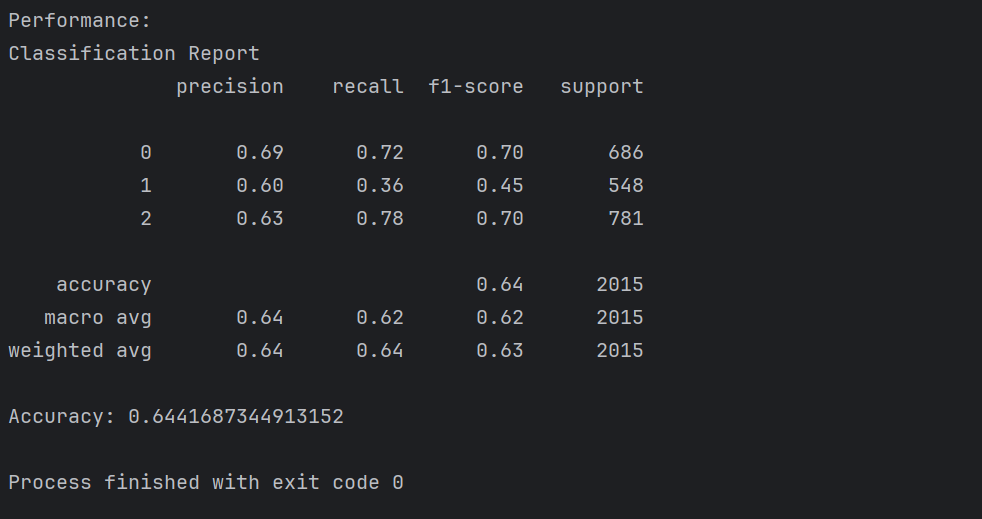

# Results analysis

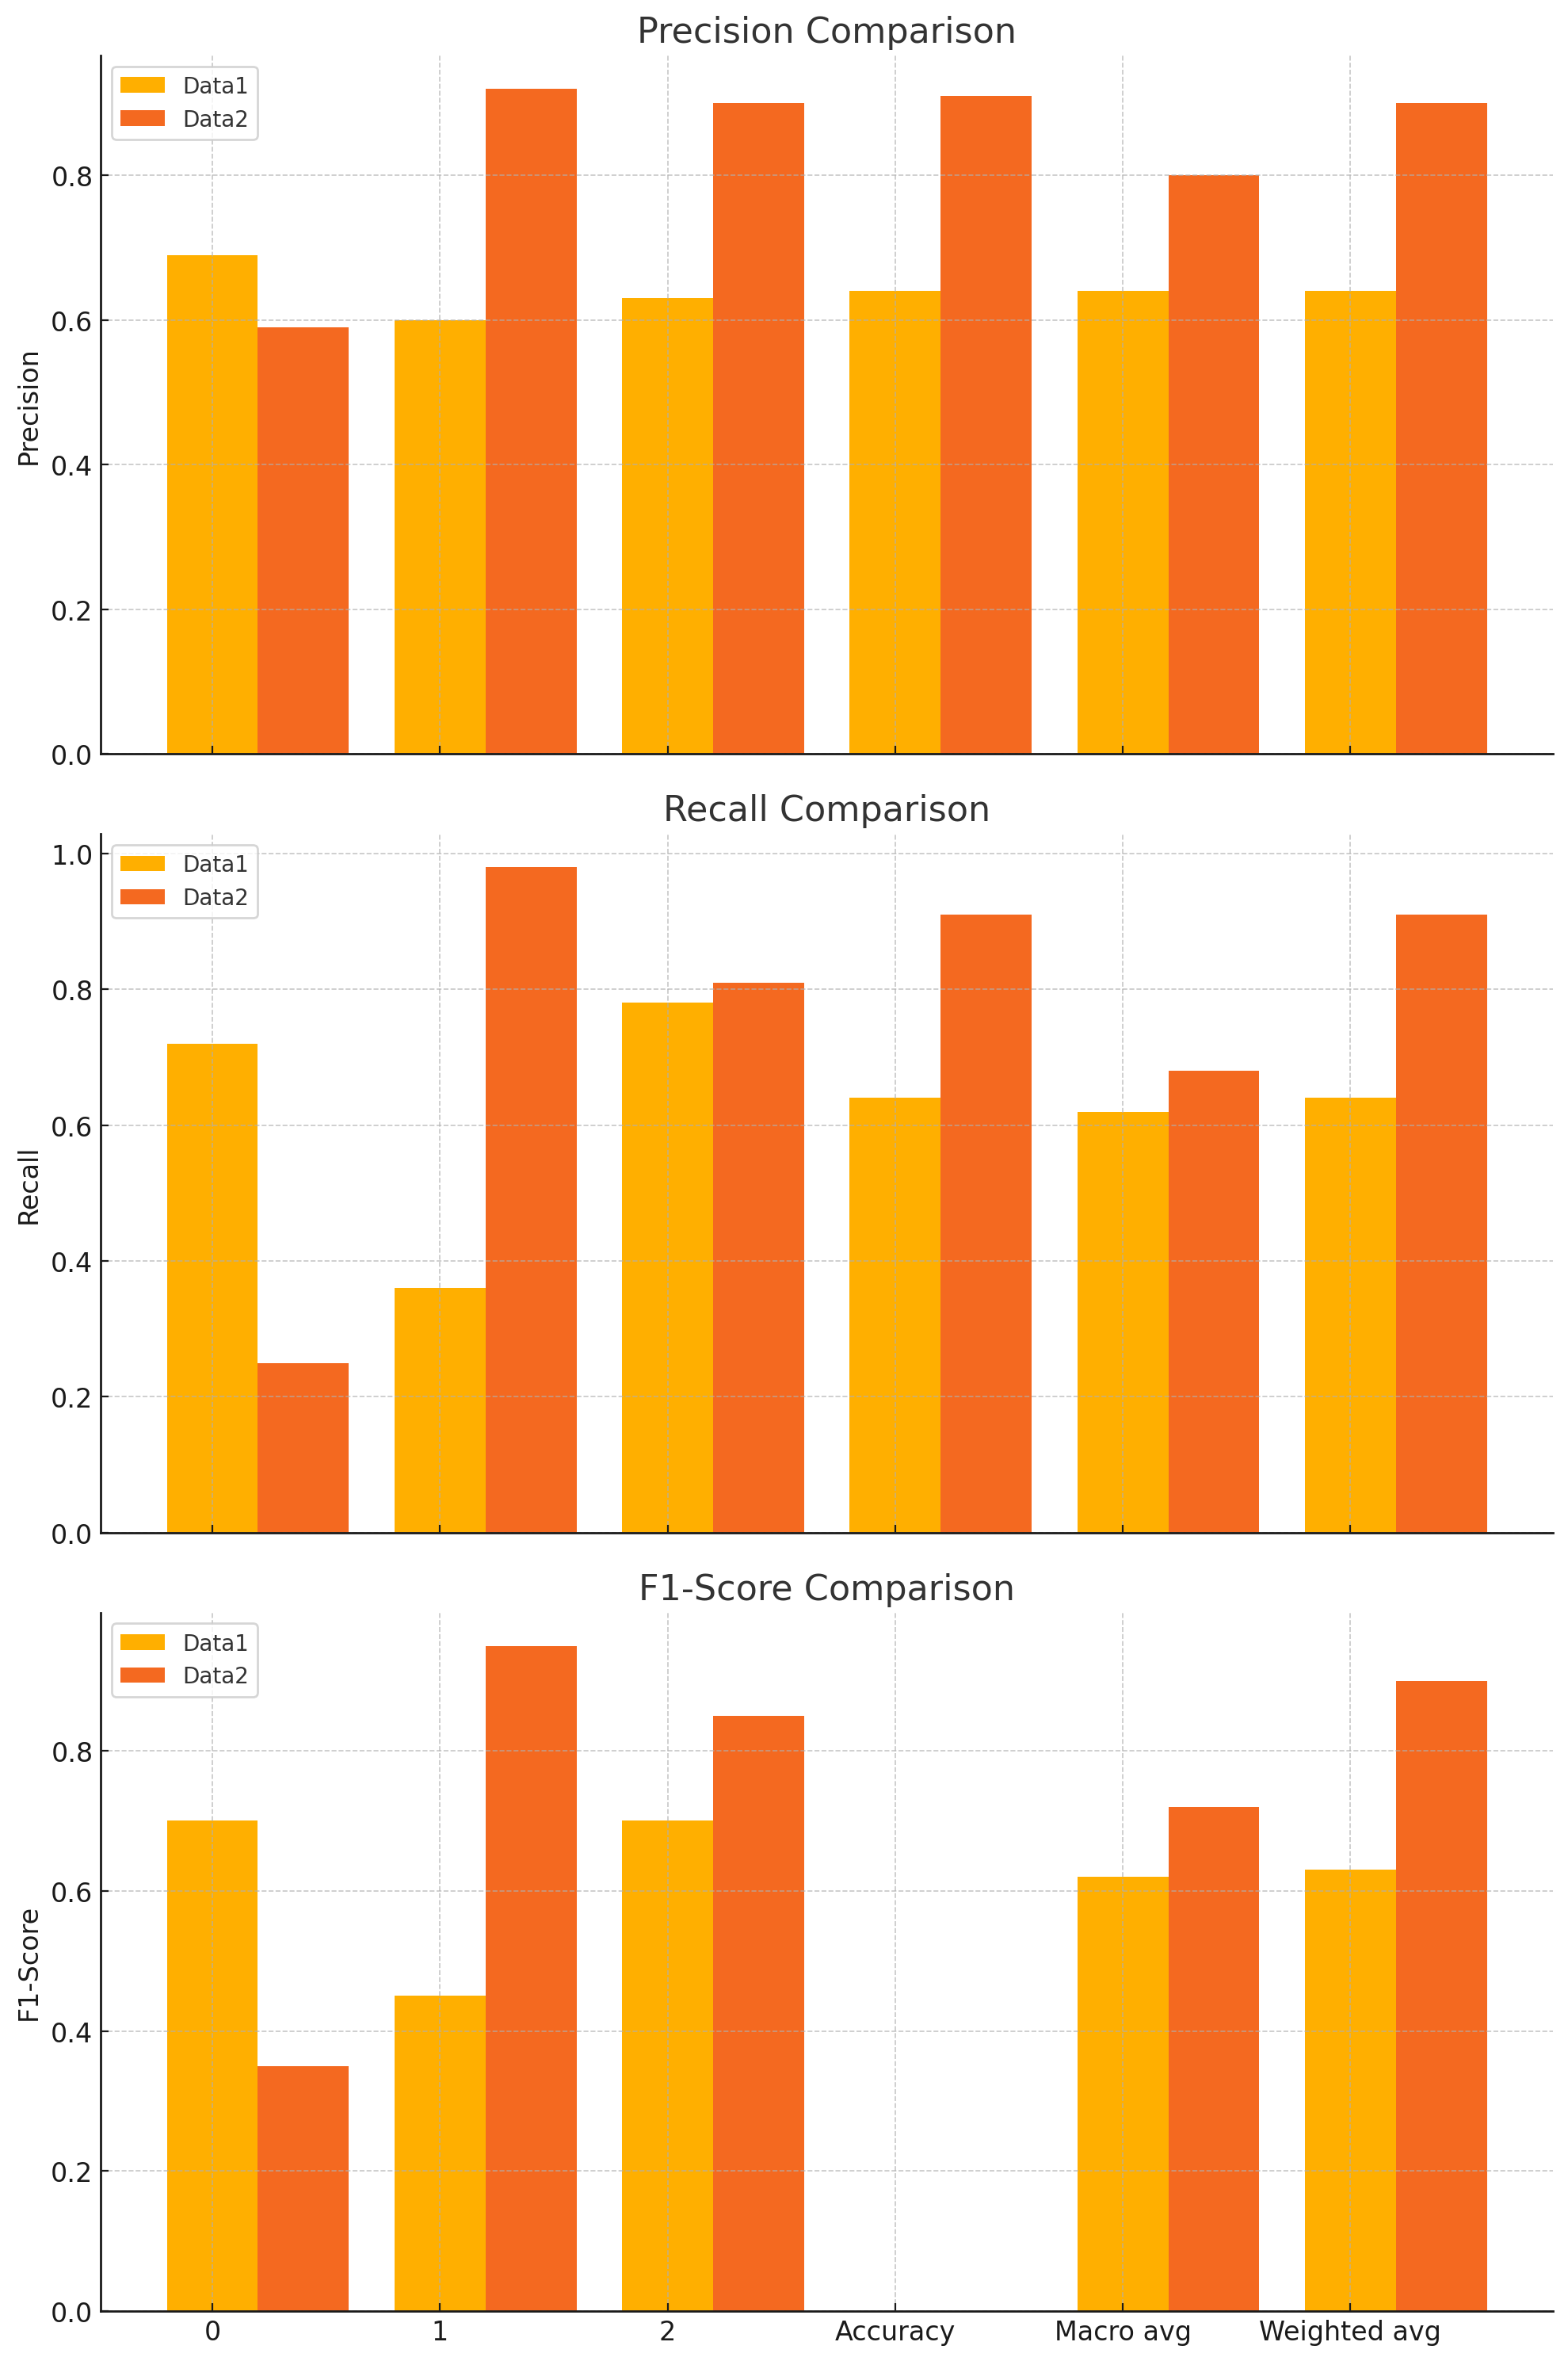

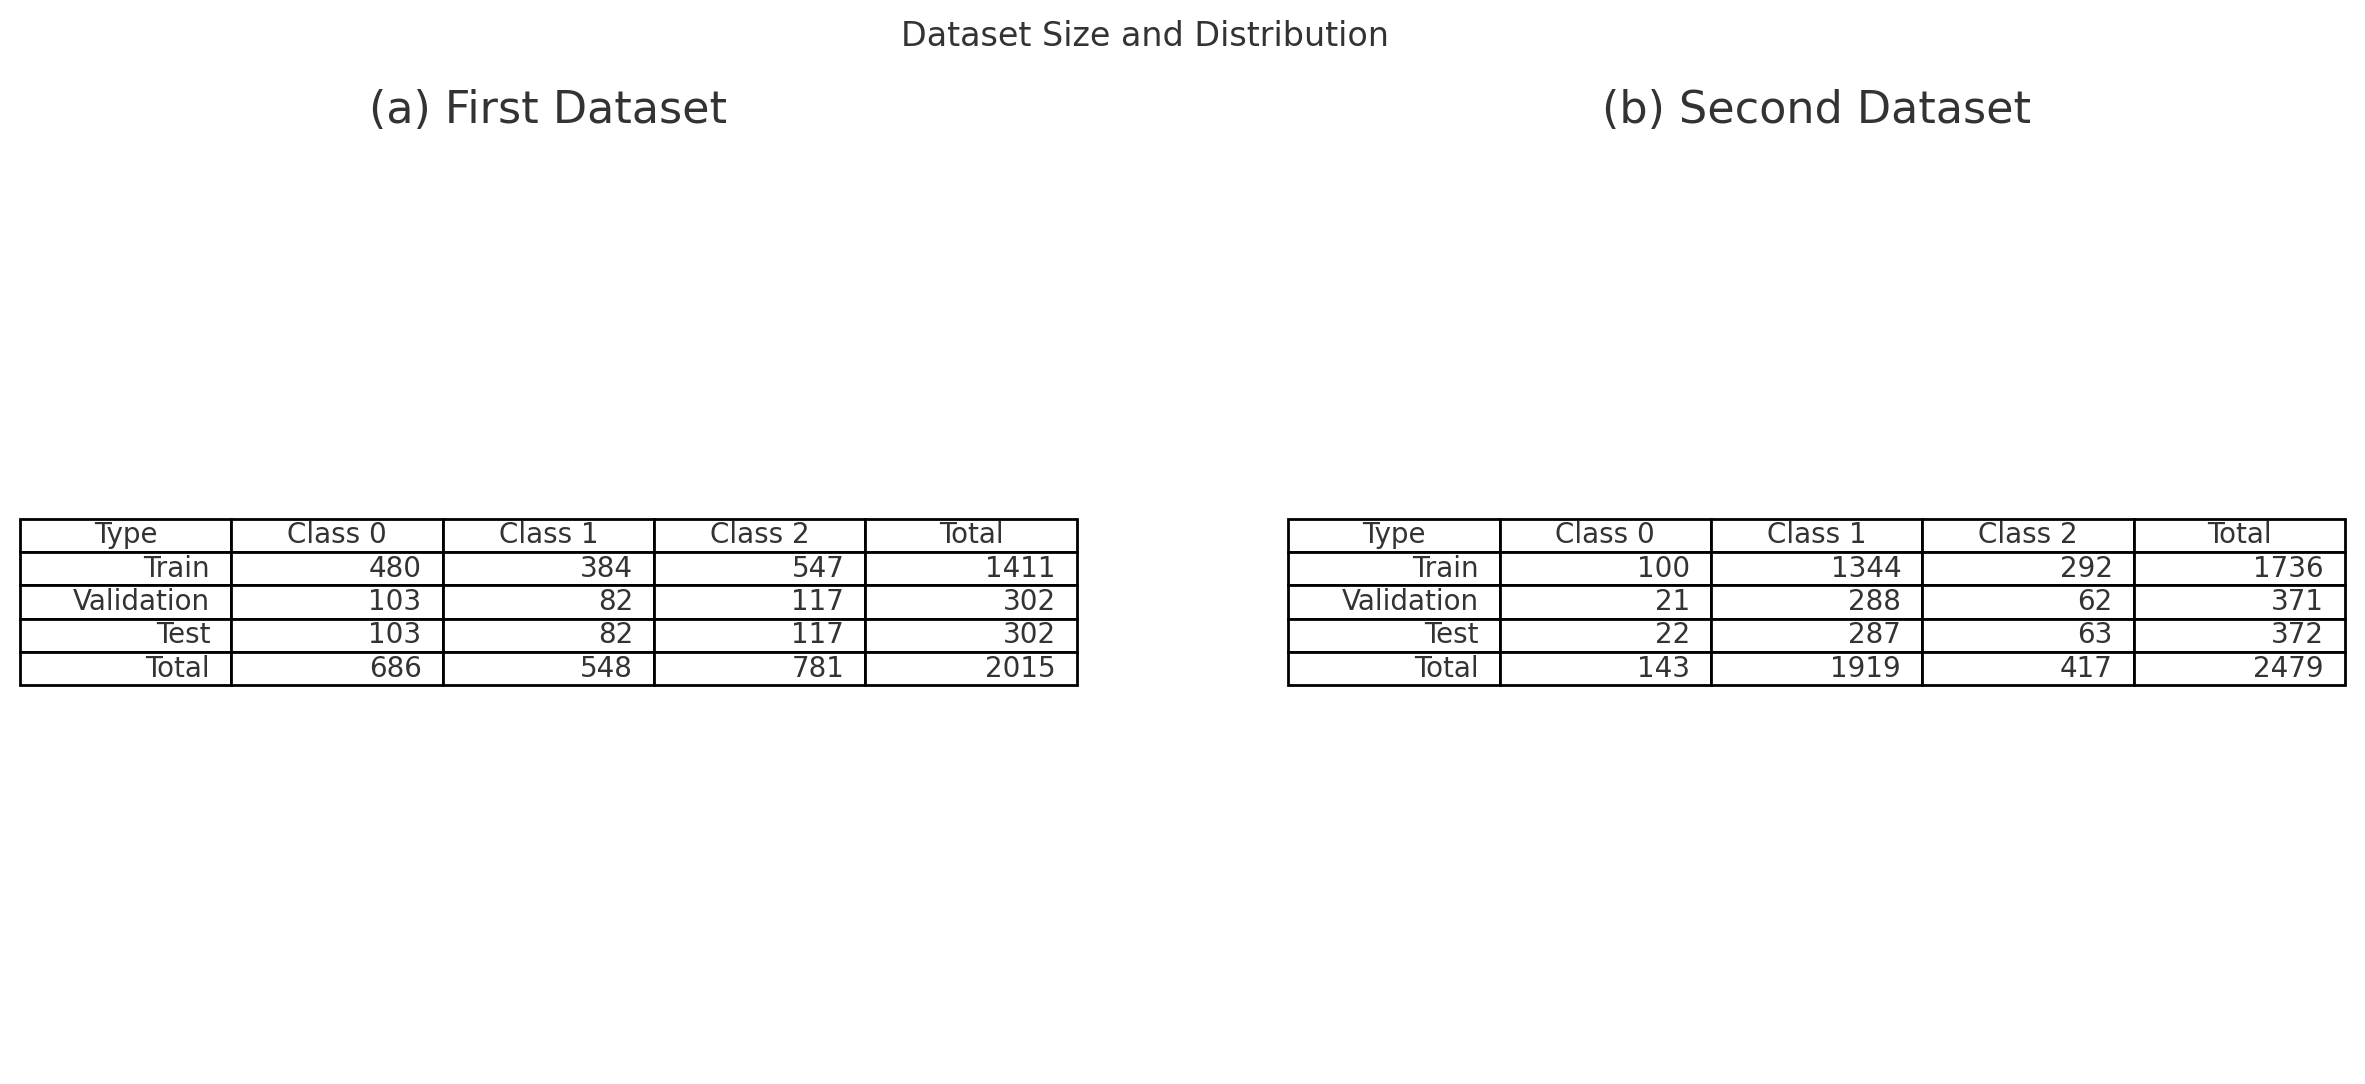

# Analysis of the Performance Differences Between the Two Datasets

1.Dataset Size and Distribution
First Dataset:
Samples in Class 0: 686
Samples in Class 1: 548
Samples in Class 2: 781
Total samples: 2015
Second Dataset:
Samples in Class 0: 143
Samples in Class 1: 1919
Samples in Class 2: 417
Total samples: 2479
The second dataset has a highly imbalanced sample distribution, with a significantly larger number of samples in Class 1 compared to the other classes. In contrast, the first dataset has a relatively more balanced distribution. This imbalance likely causes the model to perform exceptionally well on Class 1 while underperforming on other classes.

2.Dataset Size
The second dataset has more total samples, which could provide the model with more training data, potentially improving overall prediction accuracy. However, the imbalance in class distribution affects performance for certain classes.

3.Class Imbalance
In the first dataset, the recall for Class 1 is notably low (0.36), indicating difficulty in recognizing Class 1 instances.
In the second dataset, the recall for Class 1 is very high (0.98), but the recall for Class 0 is very low (0.25). This suggests the model is overfitting to Class 1 while neglecting Class 0.
4.Model Generalization
In the second dataset, the model's performance on Class 1 is exceptionally high (precision 0.92, recall 0.98), but performance on Classes 0 and 2 is lower. This indicates possible overfitting to the majority class (Class 1). This is also reflected in the weighted average metrics, where the second dataset shows higher precision and recall (0.90 and 0.91) compared to the first dataset.

5.Data Quality and Preprocessing
Data quality and preprocessing steps can also affect model performance. If the second dataset had stricter preprocessing or higher quality data, the model's performance would improve. However, class imbalance remains a significant influencing factor.

Possible ways to improve：
Address Class Imbalance

Use resampling techniques, such as oversampling the minority classes or undersampling the majority class, to balance the dataset.
Apply class weights in the loss function to reduce the model's bias towards the majority class.
Data Augmentation

Use data augmentation techniques, particularly for the minority classes, to generate more training samples.
Model Tuning

Adjust the model's hyperparameters, especially the learning rate and batch size.
Use a more complex model or an ensemble of models to improve classification performance.
More Data

Obtain more data, especially for the minority classes, to balance the dataset and improve the model's generalization ability.